In [24]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.__version__

'2.4.0-rc3'

In [2]:
datapath = "./data"

df = pd.concat([
    pd.read_csv(os.path.join(datapath, p))
    for p in os.listdir(datapath)
    if p.endswith(".csv")
]).reset_index(drop=True)

df.body = df.body.str.lower()
df.title = df.title.str.lower()

print(df.shape)

(800469, 22)


In [3]:
median_score = df.score.median()
print("Score median: %0.4f" % median_score)
df["target"] = df["score"] >= median_score

print("Target Mean: %0.4f" % df["target"].mean())

FEATURES = [
    "wh_word_count",
    "sentence_count",
    "word_count",
    "example_count",
    "n_linebreaks",
    "title_word_count",
    "title_question_marks",
    "num_question_marks",
    "n_links",
#     "n_tags",
    "n_lists",
]

x = df[FEATURES + ["body", "title"]]
y = df["target"]

Score median: 2.0000
Target Mean: 0.5932


In [4]:
y.value_counts()

True     474809
False    325660
Name: target, dtype: int64

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

train_bodies = x_train["body"]
train_titles = x_train["title"]

test_bodies = x_test["body"]
test_titles = x_test["title"]

print(x_train.shape, x_test.shape)

(640375, 12) (160094, 12)


In [6]:
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [7]:
title_train_embeddings = \
    np.vstack([encoder(s).numpy() for s in np.array_split(x_train['title'].to_numpy(), len(x_train)//5000)])

In [8]:
body_train_embeddings = \
    np.vstack([encoder(s).numpy() for s in np.array_split(x_train['body'].to_numpy(), len(x_train)//5000)])

In [9]:
title_test_embeddings = \
    np.vstack([encoder(s).numpy() for s in np.array_split(x_test['title'].to_numpy(), len(x_train)//5000)])

In [10]:
body_test_embeddings = \
    np.vstack([encoder(s).numpy() for s in np.array_split(x_test['body'].to_numpy(), len(x_train)//5000)])

In [11]:
train_data_x = np.hstack([title_train_embeddings, body_train_embeddings, x_train[FEATURES].to_numpy()])

In [12]:
test_data_x = np.hstack([title_test_embeddings, body_test_embeddings, x_test[FEATURES].to_numpy()])

In [13]:
train_data_y = y_train.map(np.float32).to_numpy()

In [14]:
test_data_y = y_test.map(np.float32).to_numpy()

In [15]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.Input(shape=(512*2+10,)),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(0*0.05))
])

In [16]:
inp = keras.Input(shape=(512*2+10,))
output = tf.concat([inp, keras.layers.Dense(50, activation='tanh')(inp)], axis=1)
for _ in range(10):
    output = tf.concat([output, keras.layers.Dense(50, activation='tanh')(output)], axis=1)
output = keras.layers.Dense(1)(output)
model = keras.Model(inputs=inp, outputs=output)

In [17]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1034)]       0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50)           51750       input_2[0][0]                    
__________________________________________________________________________________________________
tf.concat (TFOpLambda)          (None, 1084)         0           input_2[0][0]                    
                                                                 dense_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 50)           54250       tf.concat[0][0]              

In [18]:
history = model.fit(
    train_data_x,
    train_data_y,
    epochs=20,
    batch_size=4096,
    validation_data=(test_data_x, test_data_y), 
    validation_batch_size=4096,
    callbacks=[keras.callbacks.LearningRateScheduler(lambda ep, lr: 0.0005 if ep == 1 else lr * 0.99)]
)

Epoch 1/20
157/157 [==============================] - 40s 250ms/step - loss: 0.7282 - accuracy: 0.6054 - val_loss: 0.5765 - val_accuracy: 0.6840
Epoch 2/20
157/157 [==============================] - 38s 244ms/step - loss: 0.5729 - accuracy: 0.6840 - val_loss: 0.5729 - val_accuracy: 0.6764
Epoch 3/20
157/157 [==============================] - 38s 243ms/step - loss: 0.5702 - accuracy: 0.6827 - val_loss: 0.5703 - val_accuracy: 0.6776
Epoch 4/20
157/157 [==============================] - 38s 243ms/step - loss: 0.5673 - accuracy: 0.6842 - val_loss: 0.5703 - val_accuracy: 0.6942
Epoch 5/20
157/157 [==============================] - 38s 243ms/step - loss: 0.5662 - accuracy: 0.6848 - val_loss: 0.5674 - val_accuracy: 0.6912
Epoch 6/20
157/157 [==============================] - 38s 243ms/step - loss: 0.5635 - accuracy: 0.6865 - val_loss: 0.5653 - val_accuracy: 0.6793
Epoch 7/20
157/157 [==============================] - 39s 246ms/step - loss: 0.5610 - accuracy: 0.6881 - val_loss: 0.5662 - val_ac

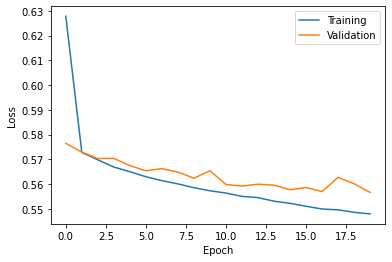

In [25]:
fig2, ax0 = plt.subplots()
ax0.plot(history.history['loss'])
ax0.plot(history.history['val_loss'])
ax0.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss');

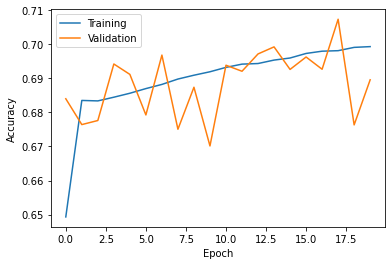

In [26]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy');